In [ ]:
# Load libraries
import math
import sys
import h5py
import pandas as pd
import numpy as np
from numpy.fft import fft, ifft
from scipy import interpolate
import matplotlib.pyplot as plt
import pywt
from scipy.io import loadmat, savemat
from scipy import signal
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow as tf
import keras.backend as K
from keras.models import Sequential,  Model
from keras.layers import Dense, LSTM, TimeDistributed, Flatten, Bidirectional, Input
from tensorflow.keras import layers
from tensorflow import keras
from keras.layers import MaxPooling2D, Conv2D, MaxPooling1D, Conv1D, Dense, Flatten, AveragePooling1D, LSTM, Dropout, Input, Concatenate, LeakyReLU, BatchNormalization, Activation
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from google.colab import files
from numpy import savetxt
from keras.layers import Layer
from xgboost import XGBRegressor
from matplotlib import pyplot
np.random.seed(0)
tf.random.set_seed(0)

In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the data
data1 = loadmat('/content/drive/My Drive/Colab Notebooks/Final_Features_Extraction_Codes/XPG/Physics_Guided_WA_No_Regularizer/Input_Output_Data_XPG_No_Reg.mat')
df = pd.DataFrame({'F1':data1['F1'].flatten().round(2),'SS':data1['SS'].flatten()})
df = df[['F1','SS']]

In [ ]:
# Function: Create Data History
def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)-1):
		end_ix = i + n_steps
		if end_ix > len(data)-1:
			break
		x1, y1 = data[i:end_ix, :-1], data[end_ix, -1]
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)

In [ ]:
# Preprocessing (SS)
arr = df.to_numpy()
n_steps = 300
xdf, ydf_SS = create_timesteps(arr, n_steps)

# Reshape
in_dim = xdf.shape[1]*xdf.shape[2]
xdf = xdf.reshape((xdf.shape[0], in_dim))

In [ ]:
# Split into train-val-test (SS)
x_train, x_test, y_train_SS, y_test_SS = train_test_split(xdf, ydf_SS, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_SS, Y_val_SS = train_test_split(x_train, y_train_SS, test_size=0.125, shuffle=False)

# Normalize the input
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_val = pd.DataFrame(scaler.transform(X_val))
x_test = pd.DataFrame(scaler.transform(x_test))

In [ ]:
## Define DD
def MLP_Data():

    # Define inputs
    X_train = layers.Input(shape=(n_steps,),name='X_train')

    # Prediction: Shear Stress + Slip Rate
    x = layers.Dense(128,kernel_initializer = 'normal', activation="relu")(X_train)
    x = layers.Dense(64,kernel_initializer = 'normal', activation="relu")(x)
    x = layers.Dense(32,kernel_initializer = 'normal', activation="relu")(x)
    ss_pred = layers.Dense(1,kernel_initializer = 'normal',activation="linear")(x)

    model = keras.Model(inputs=[X_train],outputs=[ss_pred])
    return model

In [ ]:
model = MLP_Data()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ X_train (InputLayer)            │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        38,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,897 (191.00 KB)

 Trainable params: 48,897 (191.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
2168/2181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9449 - mse: 1.9449
Epoch 1: val_loss improved from inf to 0.09597, saving model to /content/drive/My Drive/Colab Notebooks/p5270/Automatic_Physics_Based_Features_Extraction/Check.keras
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 1.9358 - mse: 1.9358 - val_loss: 0.0960 - val_mse: 0.0960
Epoch 2/100
2166/2181 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0467 - mse: 0.0467
Epoch 2: val_loss improved from 0.09597 to 0.00168, saving model to /content/drive/My Drive/Colab Notebooks/p5270/Automatic_Physics_Based_Features_Extraction/Check.keras
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0465 - mse: 0.0465 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 3/100
2173/2181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0035 - mse: 0.0035
Epoch 3: val_loss improved from 0.00168 to 0.00161, saving model to /content/drive/My Drive/Colab Notebooks/p5270/Automatic_Physics_Based_Features_Extraction/Check.keras
2181/2181 ━━━━━━━━━━━━━━

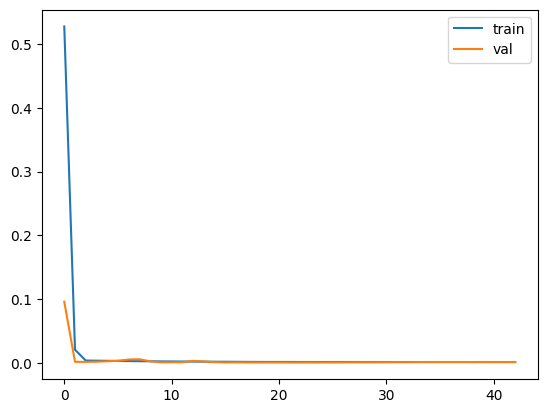

In [ ]:
# Compile & Run
model=MLP_Data()
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(1e-3), metrics=['mse'])

earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=20,verbose=1, mode='auto')
checkpoint = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/p5270/Automatic_Physics_Based_Features_Extraction/Check.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [earlystop, checkpoint]
history = model.fit([X_train],[Y_train_SS], epochs=100, batch_size=32,callbacks=callbacks_list,
                     validation_data=([X_val],[Y_val_SS]), verbose=1)
plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [ ]:
# Model Performance: Training
y_predtrain = model.predict([X_train],verbose=0)
y_predtrain_SS = np.array(y_predtrain)

train_r2_SS = r2_score(Y_train_SS, y_predtrain_SS)
train_rmse_SS = np.sqrt(mean_squared_error(Y_train_SS, y_predtrain_SS))

  # Model Performance: Validation
y_predval = model.predict([X_val],verbose=0)
y_predval_SS = np.array(y_predval)

val_r2_SS = r2_score(Y_val_SS, y_predval_SS)
val_rmse_SS = np.sqrt(mean_squared_error(Y_val_SS, y_predval_SS))

  # Model Performance: Testing
y_predtest = model.predict([x_test],verbose=0)
y_predtest_SS = np.array(y_predtest)

test_r2_SS = r2_score(y_test_SS, y_predtest_SS)
test_rmse_SS = np.sqrt(mean_squared_error(y_test_SS, y_predtest_SS))

  # Print R2 Results
print("R2 scores: Train (SS) - %0.5f" %(train_r2_SS))
print("R2 scores: Validation (SS) - %0.5f" %(val_r2_SS))
print("R2 scores: Testing (SS) - %0.5f" %(test_r2_SS))

  # Print RSME Results
print("RMSE scores: Train (SS) - %0.5f" %(train_rmse_SS))
print("RMSE scores: Validation (SS) - %0.5f" %(val_rmse_SS))
print("RMSE scores: Testing (SS) - %0.5f" %(test_rmse_SS))

R2 scores: Train (SS) - 0.91806
R2 scores: Validation (SS) - 0.91269
R2 scores: Testing (SS) - 0.88080
RMSE scores: Train (SS) - 0.03521
RMSE scores: Validation (SS) - 0.03843
RMSE scores: Testing (SS) - 0.04921


In [ ]:
# # Extract Data
# # SS
# savetxt('Y_train_SS.csv', Y_train_SS, delimiter=',')
# savetxt('Y_val_SS.csv', Y_val_SS, delimiter=',')
# savetxt('y_test_SS.csv', y_test_SS, delimiter=',')
# savetxt('y_predtrain_SS.csv', y_predtrain_SS, delimiter=',')
# savetxt('y_predval_SS.csv', y_predval_SS, delimiter=',')
# savetxt('y_predtest_SS.csv', y_predtest_SS, delimiter=',')

In [ ]:
# # Download Data
# # SS
# files.download('Y_train_SS.csv')
# files.download('Y_val_SS.csv')
# files.download('y_test_SS.csv')
# files.download('y_predtrain_SS.csv')
# files.download('y_predval_SS.csv')
# files.download('y_predtest_SS.csv')